In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:

import PIL
import PIL.Image
import zipfile
import pathlib
from glob import glob
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to define the path of Dataset
path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'

In [ ]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

train_generator = image_generator.flow_from_directory(
    batch_size = 32, 
    directory= path, 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="training")

Found 4800 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(
    batch_size = 32,
    directory= path, 
    shuffle= True, 
    target_size=(256,256), 
    class_mode = 'categorical', 
    subset="validation")


Found 1200 images belonging to 4 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(32, 256, 256, 3)

In [ ]:
train_labels.shape

(32, 4)

In [ ]:
label_names = {0 : 'Covid-19', 1 : 'Lung_Opacity', 2 : 'Normal', 3 : 'Viral Pneumonia'}

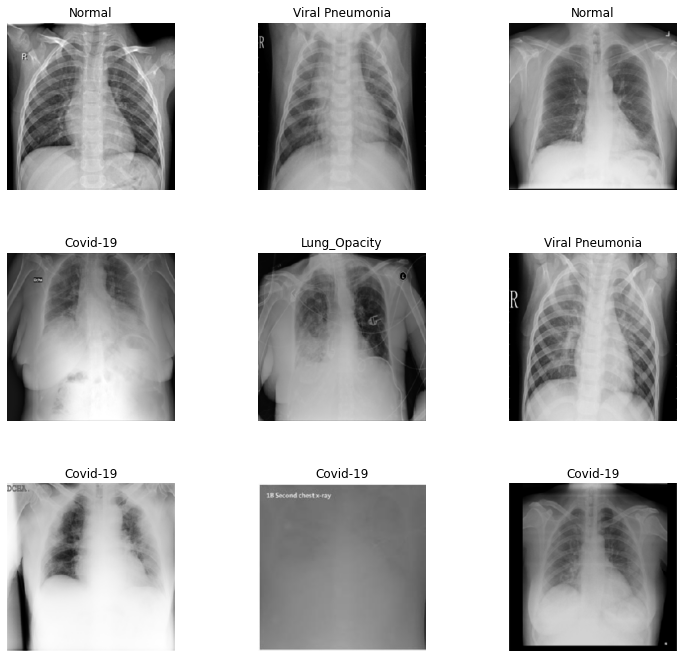

In [ ]:
# Create a grid of 36 images along with their corresponding labels
L = 3
W = 3

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#freezing the model layer for training purpose

for layer in basemodel.layers[:-10]:
  layer.trainable = False

In [ ]:
x = basemodel.output
x = AveragePooling2D(pool_size = (4,4))(x)
x = Flatten(name= 'flatten')(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation =  "relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation =  "relu")(x)
x = Dropout(0.1)(x)
x = Dense(4, activation = 'softmax')(x)

model = Model(inputs = basemodel.input, outputs = x)

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr = 1e-3, decay = 1e-3), 
              metrics= ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/Rnet_Model.h5", 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 32, 
                    epochs = 50, 
                    validation_data= val_generator, 
                    validation_steps= val_generator.n // 32, 
                    callbacks=[checkpointer, earlystopping])

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 1.4239 - accuracy: 0.4831
Epoch 00001: val_loss improved from inf to 4.17500, saving model to /content/drive/MyDrive/Colab Notebooks/Rnet_Model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


150/150 [==============================] - 970s 6s/step - loss: 1.4239 - accuracy: 0.4831 - val_loss: 4.1750 - val_accuracy: 0.4992
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.9538 - accuracy: 0.5885
Epoch 00002: val_loss improved from 4.17500 to 1.45386, saving model to /content/drive/MyDrive/Colab Notebooks/Rnet_Model.h5
150/150 [==============================] - 57s 382ms/step - loss: 0.9538 - accuracy: 0.5885 - val_loss: 1.4539 - val_accuracy: 0.5836
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.7862 - accuracy: 0.6692
Epoch 00003: val_loss improved from 1.45386 to 1.08860, saving model to /content/drive/MyDrive/Colab Notebooks/Rnet_Model.h5
150/150 [==============================] - 57s 381ms/step - loss: 0.7862 - accuracy: 0.6692 - val_loss: 1.0886 - val_accuracy: 0.5084
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.7023
Epoch 00004: val_loss improved from 1.08860 to 0.65391, saving

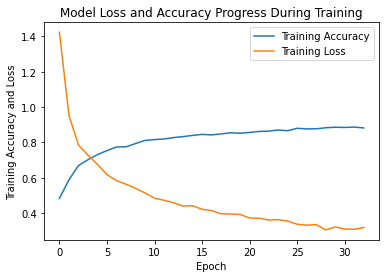

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

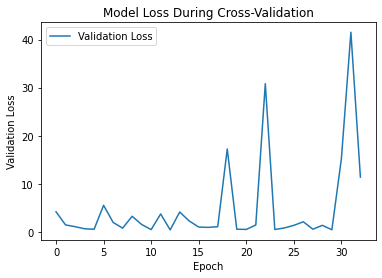

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

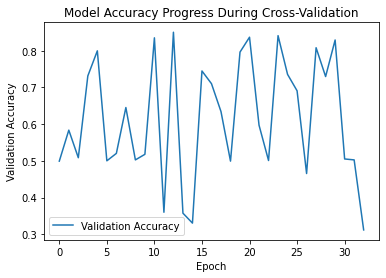

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

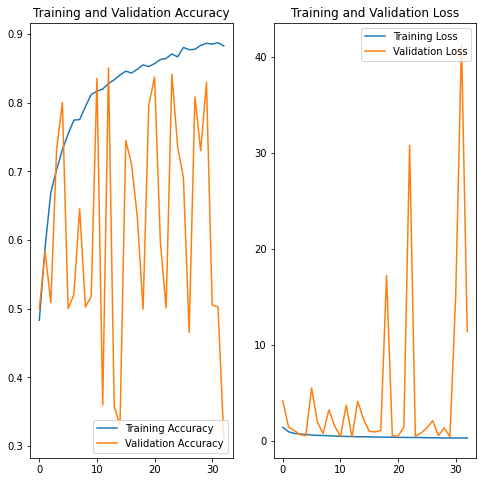

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [3]:
from keras.models import load_model
#model = './content/drive/MyDrive/Detection of Disease form X-rays images/CNN_model_4.h5'
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Rnet_Model.h5')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              